In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
import scipy as sp
from matplotlib import pyplot as plt
import time
import lib
from sklearn.linear_model import Lasso

In [2]:
rootfolder = '..'

Useful function for plot the dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Set all the paramters for the anomaly detection

In [4]:
# patch size (tha patch is square)
p = 15

# number of patches in the training set for dictionary learning
npatch_dictionary = 10000

# number of patches to estimate the confidence region
npatch_region = 1000

# paramters for the dictionary learning using the KSVD
niter_dl = 10
natom = int(np.round(p**2*1.5))
L = 4

# regularization parameters for the l1 sparse coding
lmbda = 0.18

Construct the training and validation sets
------------------------------------------

In [5]:
# load the training image and rescale it in [0,1]
img = imread(f'{rootfolder}/data/img_normal.png') / 255

# extract random patches from the image and store them in a matrices S, V
img_patches = lib.img_to_patches(img, p)
_, img_n_patches = img_patches.shape
S = img_patches[:, np.random.choice(img_n_patches, npatch_dictionary)]
V = img_patches[:, np.random.choice(img_n_patches, npatch_region)]

Dictionary Learning
-------------------
Perform preprocessing on the patches in $S$

In [6]:
# PREPROCESSING: exclude black patches from S
v = np.median(S, axis=0)
S = S[:,v > 0.06]

In [7]:
# PREPROCESSING: remove the mean from each patch
S = S - np.mean(S, axis=0)
S.shape

(225, 9440)

Perform dictionary learning via KSVD or MOD

In [8]:
# or load a precomputed dictionary
D = loadmat(f'{rootfolder}/data/dict_anom_det.mat')['D']

Show the learned dictionary

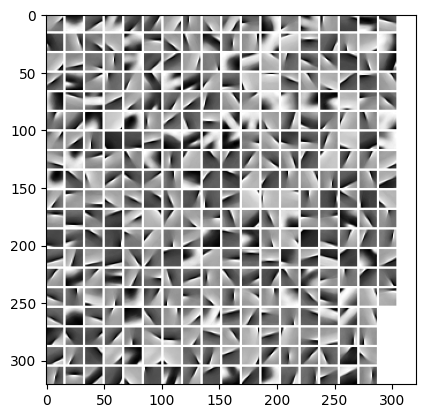

In [9]:
img_dict = get_dictionary_img(D)
plt.imshow(img_dict, cmap='gray')
plt.show()

## Confidence region estimation / density estimation

In [10]:
# PREPROCESSING: exclude black patches
v = np.median(V, axis=0)
V = V[:,v > 0.06]

In [11]:
# PREPROCESSING: remove the mean from each patch
V = V - np.mean(V, axis=0)

In [12]:
D.shape, V.shape

((225, 338), (225, 944))

In [15]:
# sparse coding of each patch in V
X = np.stack([lib.IRLS(V[:, j], D, lmbda, max_iter=1000) for j in range(V.shape[1])], axis=1)
X.shape

(338, 944)

In [16]:
X.max(), X.min()

(1.7770628253646956e-05, -1.5868955307899218e-05)

In [17]:
# computing the anomaly indicators (l1 norm, reconstruction error) for each
# patch in V

A = np.zeros((2, V.shape[1]))     # each column contains the values of the anomaly_scores for a patch

for i in range(V.shape[1]):
    A[:,i] = [
        np.linalg.norm(V[:, i] - D @ X[:, i]),
        np.linalg.norm(X[:, i], 1)
    ]

# Estimation of mean and covariance
mu = np.mean(A, axis=1)
Sigma = np.cov(A)
mu, Sigma

(array([4.05097012e+00, 8.42214112e-04]),
 array([[1.43918973e+00, 3.39807201e-04],
        [3.39807201e-04, 9.28168314e-08]]))

In [18]:
# estimation of the threshold that gives the desired false positive rate
# using the patches in V

FPR_target = 0.15

# compute the mahalanobis distance for each indicator vector in A
mahal_dist = np.zeros(V.shape[1])
for i in range(A.shape[1]):
   mahal_dist[i] = sp.spatial.distance.mahalanobis(A[:,i], mu, np.linalg.inv(Sigma))

# set the threshold
threshold = np.percentile(mahal_dist, 100*(1-FPR_target))

In [19]:
threshold

1.8978909177812724

## Test phase

In [20]:
# load the test image
img_test = imread(f'{rootfolder}/data/img_anom.png') / 255

imsz = img_test.shape

STEP = 7
# initialize the estimated image
heatmap = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [22]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = img_test[i:i+p, j:j+p].flatten()

        # if the median of s is to small set the anomaly score to 0:
        if np.median(s) <= 0.06:
            score = 0
        else:
            # subratct the mean to the patch
            s = s - np.mean(s)

            # perform the sparse coding
            x = lib.IRLS(s, D, lmbda, max_iter=1000)

            # compute the anomaly indicators vector
            a = np.array([
                np.linalg.norm(s - D @ x),
                np.linalg.norm(x, 1)
            ])

            # compute the anomaly score
            score = sp.spatial.distance.mahalanobis(a, mu, np.linalg.inv(Sigma))

        # update the heatmap
        heatmap[i:i+p, j:j+p] += score

        # update the weight matrix
        weights[i:i+p, j:j+p] += 1

In [23]:
# normalize the heatmap
heatmap = heatmap / weights

/var/folders/29/68f5_tk131x7cx496z5c3sxr0000gn/T/ipykernel_87352/3950609915.py:2: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap / weights


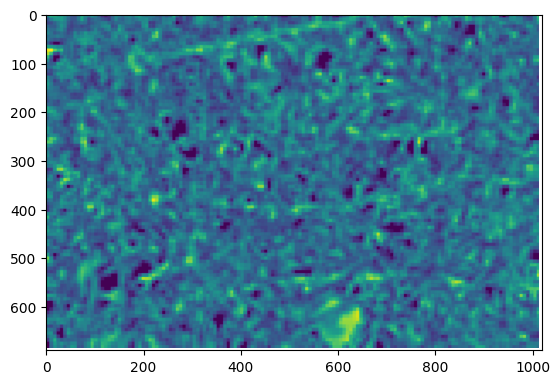

In [24]:
# plot the heatmap
plt.imshow(heatmap);

In [25]:
# build the detection mask, that has the same size of the test image
# each pixel in the mask has value 1 if the corresponding patch has been
# detected as anomalous, otherwise it has value 0
mask = heatmap > threshold

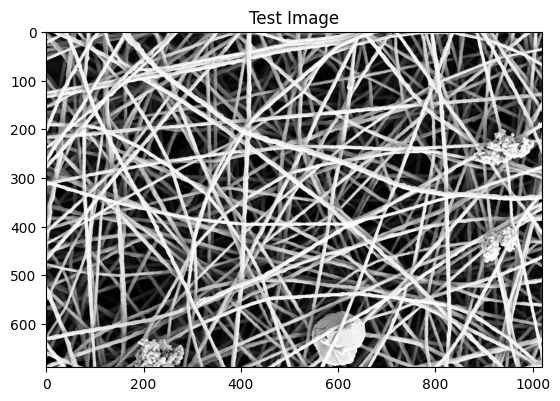

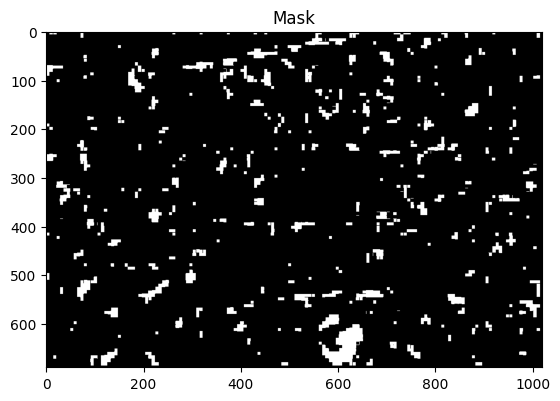

In [26]:
## show the results
plt.figure(3), plt.imshow(img_test, cmap='gray'), plt.title('Test Image')
plt.figure(4), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.show();

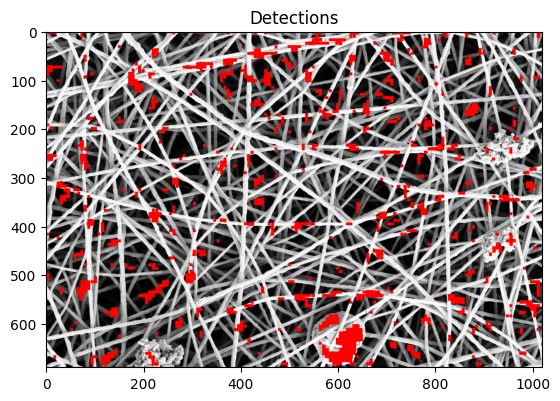

In [27]:
# combine the mask and the test image
img_color = np.zeros([img_test.shape[0], img_test.shape[1], 3])
img_temp = img_test.copy()
img_temp[mask > 0] = 1
img_color[:,:,0] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,1] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,2] = img_temp

plt.figure(5), plt.imshow(img_color), plt.title('Detections')
plt.show();